# per-line transcription with LLM & OCR

In [1]:
from openai import OpenAI
import os
import re
import pandas as pd
from dotenv import load_dotenv
import requests
import base64
import subprocess
from IPython.display import display, Image
from PIL import Image as PILImage

In [2]:
import cv2
import easyocr
import matplotlib.pyplot as plt
import pytesseract
import keras_ocr

In [3]:
path = os.path.dirname(os.getcwd()) # Parent directory
image_folder = path+'/data/lines'

In [4]:
# OpenAI
load_dotenv() #get the environment 
openai_API_KEY = os.getenv("OPENAI_API_KEY")
openai_client = OpenAI(api_key=openai_API_KEY)

In [5]:
load_dotenv() 
anthropic_API_KEY = os.getenv("ANTHROPIC_API_KEY")
anthropic_client = OpenAI(api_key=anthropic_API_KEY)
MODEL_NAME = "claude-3-5-sonnet-20240620"

## Read and encode the images

In [5]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [6]:
images = []
for image in os.listdir(image_folder):
    if image.endswith('.jpg'):
        images.append(image)

rows = []
for image in images:
    name = image.split('.')[0]
    name_split = name.split('_')[0]
    file_name = name_split.split('example')[1]
    line_name = name.split('_')[1]
    encoded_value = encode_image(image_folder+'/'+image)
    rows.append({'file': file_name, 'line': line_name, 'encoded': encoded_value})

images_encoded = pd.DataFrame(rows)

In [7]:
images_encoded['file'] = images_encoded['file'].astype('int')
images_encoded['line'] = images_encoded['line'].astype('int')
images_encoded = images_encoded.sort_values(by=['file', 'line']).reset_index(drop=True)
images_encoded['id'] = images_encoded['file'].astype(str) + '_' + images_encoded['line'].astype(str)
images_encoded.head(30)

,file,line,encoded,id
0,1,0,/9j/4QczRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_0
1,1,1,/9j/4QZBRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_1
2,1,2,/9j/4QX5RXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_2
3,1,3,/9j/4QYvRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_3
4,1,4,/9j/4QZLRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_4
5,1,5,/9j/4QVaRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_5
6,1,6,/9j/4QVqRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_6
7,1,7,/9j/4QX5RXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_7
8,1,8,/9j/4QWRRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_8
9,1,9,/9j/4QZyRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_9


# LLMs

## Zero-shot GPT

In [8]:
prompt = """
    Recognize the text from the image:
    ```plaintext
"""


# I didn't consider the header.. I'm unsure whether we need to include in the analysis.
# prompt_complex = """
#     Recognize the text from the image:
    
#     Tips:
#     It's an old Belgian document written in French.
#     Unless the text starts with "Arrêté le \d{2} \w+ \d{4}( \w+)? servais" or some cells contain notes, each cell in the image usually contains the following information
#     - Number / date / Family Name/ First Name/ Location/ Date/ One or more full names. Often ends with "& autres"/number/ number/number/number/number with a year/ number with a year/ date/date/number/date/number
# """

In [9]:
def callOpenAI(prompt, max_tokens=800, base64_image=None):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai_API_KEY}"
    } 
    model_vision = "gpt-4o"
    payload = {
        "model": model_vision, # only gpt-4o can handle images
        "messages": [
        {
            "role": "system",
            "content": "You are a helpful assistant who can read old handwriting with a background in history, and you are going to recreate a scanned déclaration de succession from Belgium in a txt format."
            
        },
        {
            "role": "user",
            "content": [
            {
                "type": "text",
                "text": prompt
            },
            {
                "type": "image_url",
                "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
                }
            }
            ]
        }
        ],
        "max_tokens": max_tokens,
        "temperature": 0
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    try:
        return response.json()["choices"][0]["message"]["content"]
    except:
        print(response.json()["error"]["message"])

In [10]:
def callPostProcessing(max_tokens=800, prompt_parameter = None):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai_API_KEY}"
    } 
    payload = {
        "model": "gpt-4o",
        "messages": [
        {
            "role": "user",
            "content": [
            {
                "type": "text",
                "text": f"""This is an output from you. Clean it such that we have no separators and no comment from you: {prompt_parameter}
                """
            }
            ]
        }
        ],
        "max_tokens": max_tokens,
        "temperature": 0
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    try:
        return response.json()["choices"][0]["message"]["content"]
    except:
        print(response.json()["error"]["message"])


In [4]:
import time
import json

# Load previous progress if available
try:
    with open('gpt_output_progress.json', 'r') as file:
        gpt_output = json.load(file)
except FileNotFoundError:
    gpt_output = {}

# Loop through each unique id
# for id in images_encoded['id'].unique():
# for id in unable_ids_11:
# # for id in unable_ids:
#     # Check if this ID is already processed (Skip this step if you want to re-process for unable_ids) ----------------
#     # if id in gpt_output:
#     #     print(f"Skipping {id}, already processed.")
#     #     continue
    
#     start_time = time.time()
#     try:
#         print(f'------- Start processing file {id} -------')
        
#         # Call OpenAI and post-processing functions
#         prompt += "Even if it is hard to read the texts from the image, return as much as you can. You must read something. Do not return an apologetic message."
#         output = callOpenAI(prompt=prompt, max_tokens=800, base64_image=images_encoded[(images_encoded['id'] == id)].encoded.values[0])
#         output_cleaned = callPostProcessing(prompt_parameter=output)
        
#         # Save the output
#         gpt_output[id] = output_cleaned
        
#         # Save progress after each file
#         with open('gpt_output_progress.json', 'w') as file:
#             json.dump(gpt_output, file)
        
#         print(f'------- Finished processing file {id} in {time.time() - start_time} seconds -------')

#     except Exception as e:
#         print(f"Error processing file {id}: {str(e)}")
#         # Save the progress and exit the loop in case of an error
#         with open('gpt_output_progress.json', 'w') as file:
#             json.dump(gpt_output, file)
#         break  # Exit the loop on error

# Once all IDs are processed, save the final result
with open('gpt_output_final.json', 'w') as file:
    json.dump(gpt_output, file)

print("Processing complete.")


Processing complete.


In [5]:
gpt_output

{'1_0': "N° d'ordre (1) DATE DU DÉPÔT des DÉCLARATIONS. DÉSIGNATION DES PERSONNES DÉCÉDÉES, OU ABSENTES. NOMS. PRÉNOMS. DOMICILES DATE DU DÉCÈS ou du JUGEMENT D'ENVOI en possession, en cas d'absence. NOMS, PRÉNOMS ET DEMEURES DES PARTIES DÉCLARANTES. DROITS DE SUCCESSION EN LIGNE COLLATERALE ET DE MUTATION EN LIGNE DIRECTE. ACTIF. (2) PASSIF. (2) RESTANT NET. (2) DROIT DE MUTATION par décès. VALEUR des IMMEUBLES. (2) NUMÉROS des DÉCLARATIONS. registres supplémentaires. DATE de l'expiration du délai de restitution. NUMÉROS de la consignation des droits au sommaire n° 25. RECETTE des DROITS ET AMENDES. DATE N° CAUTIONNEMENTS. NUMÉROS de la consignation au sommaire n° 30. OBSERVATIONS. (Les déclarations qui figurent à l'état n° 11 doivent être intégrées en exécution, dans la présente colonne.)",
 '1_1': 'Écrit le vingt-huit octobre 1919 Anvers',
 '1_2': 'Arrêté le vingt neuf octobre 1919 Servais',
 '1_3': '398 trente octobre Herrenx Alphonse Joseph Opheim 1969913 Heverant Clovis autres 22

In [20]:
unable_ids = [id for id, content in gpt_output.items() if "I'm unable" in content or "sorry" in content]
print(unable_ids, len(unable_ids), sep='\n')

NameError: name 'unable_ids' is not defined

In [17]:
unable_ids_11 = [id for id, content in gpt_output.items() if "I'm unable" in content or "sorry" in content or "The image" in content] #After the second run
print(unable_ids_11, len(unable_ids_11), sep="\n")

['2_1', '3_1', '9_11', '13_11', '13_13', '14_6', '16_3', '16_8']
8


In [111]:
print(len(unable_ids), len(unable_ids_2), len(unable_ids_3), len(unable_ids_4), len(unable_ids_5), len(unable_ids_6), len(unable_ids_7),  len(unable_ids_8),  len(unable_ids_9), sep="\n")

37
21
16
12
11
11
9
9
9


### To run with the saved json

In [6]:
gpt_output_df = pd.DataFrame(gpt_output.items(), columns=['id', 'content'])

In [7]:
gpt_output_df['content'] = gpt_output_df['content'].replace('\n', ' ')
gpt_output_df

,id,content
0,1_0,N° d'ordre (1) DATE DU DÉPÔT des DÉCLARATIONS....
1,1_1,Écrit le vingt-huit octobre 1919 Anvers
2,1_2,Arrêté le vingt neuf octobre 1919 Servais
3,1_3,398 trente octobre Herrenx Alphonse Joseph Oph...
4,1_4,398½ d. Lefèvre Jules Avenue de l'Yser 5 janvi...
...,...,...
278,20_9,19 trépassé Pékiaux Cornélie Nivelles 12 avril...
279,20_10,19² 5 Dubois Alexandre décédé le 1er août 1919...
280,20_11,Arrêté le dix-neuf février 1920 Servais
281,20_12,Bruxelles vingt février 1924


In [8]:
gpt_output_df.rename(columns={'content': 'text'}, inplace=True) #To ensure the same column name as df below.

## CER/BLEU calculation

In [9]:
from glob import glob

text_path = path+'/data/transcriptions'
file_list = glob(os.path.join(text_path, 'transcription_ex*.txt'))

df_list = []

for file in file_list:
    with open(file, 'r', encoding='utf-8') as f:
        content = f.read()
    lines = content.split('\n')

    df = pd.DataFrame({
        'line': range(0, len(lines)),  # Line numbers starting from 0
        'text': lines
    })
    
    name = os.path.basename(file)
    name = name.split('.')[0]
    df['file'] = name.split('ex')[1]
    df['file'] = df['file'].astype(int)
    df_list.append(df)
df = pd.concat(df_list, ignore_index=True)

In [10]:
df['text'] = df['text'].str.replace('\t', ' ')
df = df.sort_values(by=['file', 'line']).reset_index(drop=True)
df

,line,text,file
0,0,N' d'ordre Date du dépot des déclarations Dé...,1
1,1,Nom. Prénoms Domiciles Actif. (2) Passif. (2) ...,1
2,2,arrêté le vingt huit octobre 1919 servais ...,1
3,3,arrêté le vingt neuf octobre 1919 servais ...,1
4,4,398 trente octobre Herrent Alphones gh Ophain ...,1
...,...,...,...
299,10,19 dix neuf d Pétriaux Coralie Nivelles 22 av...,20
300,11,19^2 d Dubois Alexandre Quenast 7b 1919 Dubois...,20
301,12,Arrêté le dix neuf février 1920 servais,20
302,13,Arrêté le vingt février 1920 servais,20


In [11]:
# Merge the text values of line number 0 and 1 (the two lines of the header)
for file in df['file'].unique():
    header_lines = df[(df['file'] == file) & (df['line'].isin([0, 1]))]
    df.loc[header_lines.index[0], 'text'] = header_lines.iloc[0]['text'] + " " + header_lines.iloc[1]['text']
df = df[df['line'] != 1].reset_index(drop=True)

In [12]:
df.loc[df['line'] != 0, 'line'] -= 1  # Adjust line numbers after removing the second line of the header

In [13]:
# for file 6, two lines are used for some column.. we need to merge them
doubled_line = df[(df['file'] == 6) & (df['line'].isin([3, 4]))]
df.loc[doubled_line.index[0], 'text'] = doubled_line.iloc[0]['text'] + " " + doubled_line.iloc[1]['text']
df.drop(doubled_line.index[1], inplace=True)
df.loc[(df['file'] == 6) & (df['line'] > 4), 'line'] -= 1


In [14]:
df[df['file']==6]

,line,text,file
72,0,N' d'ordre Date du dépot des déclarations Dé...,6
73,1,1921,6
74,2,150 vingt quatre juin Lambert Valentin Nivell...,6
75,3,151 d Leveau Adolphine Clabecq 8 mars 1919 Va...,6
77,4,152 d Vanpée Frédéric d 29 Db 1920 d 7122 594...,6
78,5,153 d Delabij Joachim Joseph Wauthier-Braine ...,6
79,6,Arrêté le vingt quatre juin 1921 servais,6
80,7,153(2) vingt cinq juin Charlier Hortense Nive...,6
81,8,Arrêté le vingt cinq juin 1921 servais,6
82,9,Arrêté le vingt six juin 1921 dimanche servais,6


In [15]:
df['id'] = df['file'].astype(str) + '_' + df['line'].astype(str)
df

,line,text,file,id
0,0,N' d'ordre Date du dépot des déclarations Dé...,1,1_0
1,1,arrêté le vingt huit octobre 1919 servais ...,1,1_1
2,2,arrêté le vingt neuf octobre 1919 servais ...,1,1_2
3,3,398 trente octobre Herrent Alphones gh Ophain ...,1,1_3
4,4,398^2 d Lefévre Jules Braine l'Alleud 8 Janvie...,1,1_4
...,...,...,...,...
279,9,19 dix neuf d Pétriaux Coralie Nivelles 22 av...,20,20_9
280,10,19^2 d Dubois Alexandre Quenast 7b 1919 Dubois...,20,20_10
281,11,Arrêté le dix neuf février 1920 servais,20,20_11
282,12,Arrêté le vingt février 1920 servais,20,20_12


In [16]:
print(df['id'].nunique(), gpt_output_df['id'].nunique())

283 283


## Calculate

In [17]:
from evaluate import load

cer_metric =load("cer")
bleu_metric = load("bleu")  

In [18]:
bleu_gpt = {}
cer_gpt = {}

for id in df['id']:
    # Extract the text as a single string, not as an array
    pred_text = gpt_output_df[gpt_output_df['id'] == id]['text'].values[0]
    ref_text = df[df['id'] == id]['text'].values[0]

    # Ensure the predictions and references are passed as a list of strings
    bleu_gpt[id] = bleu_metric.compute(predictions=[pred_text], references=[ref_text])
    cer_gpt[id] = cer_metric.compute(predictions=[pred_text], references=[ref_text])


In [19]:
bleu_gpt = pd.DataFrame(bleu_gpt).T

In [21]:
print(bleu_gpt['bleu'].mean(), bleu_gpt['bleu'].var())

0.15490614052057017 0.052481467008593366


In [30]:
bleu_gpt['id'] = bleu_gpt.index
bleu_gpt

,bleu,precisions,brevity_penalty,length_ratio,translation_length,reference_length,id
1_0,0.222939,"[0.4713375796178344, 0.26282051282051283, 0.18...",1.0,1.032895,157,152,1_0
1_1,0.0,"[0.5, 0.2, 0.0, 0.0]",0.846482,0.857143,6,7,1_1
1_2,0.614788,"[0.7142857142857143, 0.6666666666666666, 0.6, ...",1.0,1.0,7,7,1_2
1_3,0.0,"[0.3333333333333333, 0.11764705882352941, 0.06...",0.606531,0.666667,18,27,1_3
1_4,0.0,"[0.16666666666666666, 0.0, 0.0, 0.0]",0.606531,0.666667,12,18,1_4
...,...,...,...,...,...,...,...
20_9,0.279971,"[0.7058823529411765, 0.5, 0.3333333333333333, ...",0.702619,0.73913,17,23,20_9
20_10,0.0,"[0.4444444444444444, 0.23529411764705882, 0.06...",0.800737,0.818182,18,22,20_10
20_11,0.0,"[0.6666666666666666, 0.4, 0.0, 0.0]",0.846482,0.857143,6,7,20_11
20_12,0.0,"[0.5, 0.3333333333333333, 0.0, 0.0]",0.606531,0.666667,4,6,20_12


In [33]:
bleu_gpt['file'] = bleu_gpt['id'].str.split('_').str[0].astype(int)
bleu_gpt.groupby('file')['bleu'].agg(['mean', 'var'])

,mean,var
file,,
1,0.25544,0.06741
2,0.151111,0.056899
3,0.074002,0.021198
4,0.159369,0.06044
5,0.069426,0.01423
6,0.150828,0.061054
7,0.024414,0.005148
8,0.207317,0.044887
9,0.144383,0.043662


In [26]:
bleu_gpt.to_csv(path+'/results/comparisons/bleu_gpt_perline.csv')

In [22]:
cer_gpt = pd.DataFrame(cer_gpt.items(), columns=['id', 'cer'])

In [23]:
print(cer_gpt['cer'].mean(), cer_gpt['cer'].var())

0.452351054128772 0.24622493183201774


In [27]:
cer_gpt.to_csv(path+'/results/comparisons/cer_gpt_perline.csv')

In [35]:
cer_gpt['file'] = cer_gpt['id'].str.split('_').str[0].astype(int)
cer_gpt.groupby('file')['cer'].agg(['mean', 'var'])

,mean,var
file,,
1,0.306472,0.038646
2,0.369377,0.044723
3,0.761383,1.622218
4,0.300475,0.026677
5,0.431684,0.080848
6,0.379197,0.023176
7,0.422762,0.024131
8,0.372903,0.022474
9,0.575670,0.439224


# OCR

## EasyOCR

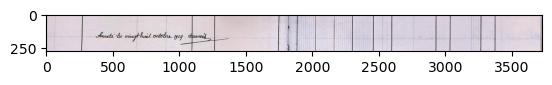

In [148]:
test_image = cv2.imread(test_path)
plt.imshow(test_image)

In [164]:
def easyOCR(image_path):
    reader = easyocr.Reader(['fr'])
    img = cv2.imread(image_path)
    results = reader.readtext(img)
    output = []
    for res in results:
        det, conf = res[1], res[2]
        output.append((det, round(conf, 2))) 
    text = ' '.join([i[0] for i in output])
    return text

In [165]:
test_ocr = easyOCR(test_path)

In [166]:
test_ocr

'~Bcrta` 8 oetolz 1919 d4earuey vicytAul'

### Pytesseract

In [167]:
def pytesseractOCR(image_path):
    try:
        image = Image.open(image_path)
        text = pytesseract.image_to_string(image)
        return text
    except:
        print("[ERROR] pytesseractOCR failed! (should be installed)")
        return ""

In [168]:
test_pytesseract = pytesseractOCR(image_path=test_path)
print(test_pytesseract)

[ERROR] pytesseractOCR failed! (should be installed)



### Keras

Not good for non-english?

In [172]:
def kerasOCR(image_path):
    pipeline = keras_ocr.pipeline.Pipeline()
    image = keras_ocr.tools.read(image_path)
    prediction_groups = pipeline.recognize([image])
    words = []
    for line in prediction_groups[0]:
        for word in line:
            try:
                if isinstance(word[0], str):
                    words.append(word[0])
            except IndexError:
                continue
    text = ' '.join(words)
    return text

In [173]:
test_keras = kerasOCR(image_path=test_path)
print(test_keras)

Looking for /Users/serenekim/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.
Looking for /Users/serenekim/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 1s 751ms/step
d r p o a g


# Pipeline

In [113]:
gpt4o_texts = []
easyOCR_texts = []
# pytesseract_texts = []
# kerasOCR_texts = []

# for file in images_encoded['file'].unique():
for file in [1]:
    print(f"File: {file}")
    for line in images_encoded[images_encoded['file'] == file]['line']:
        print(f"Line: {line}")
        image_path = image_folder+f'/example{file}_{line}.jpg'
        input_encoded_image = images_encoded[(images_encoded['file'] == file) & (images_encoded['line'] == line) ]['encoded'].values[0]
        
###### GPT-4o
        line_text_gpt4o = callOpenAI(prompt=prompt, max_tokens=800, base64_image = input_encoded_image)
        # print(f"OpenAI: {line_text_gpt4o}")
        postprocessed_gpt40_text = callPostProcessing(max_tokens=800, prompt_parameter = line_text_gpt4o)
        gpt4o_texts.append({'file': file, 'line': line, 'gpt4o_text': postprocessed_gpt40_text})
        line_text_complex = callOpenAI(prompt=prompt_complex, max_tokens=800, base64_image = input_encoded_image)
        print(f"OpenAI Complex: {line_text_complex}")

###### EasyOCR
        line_text_easyOCR = easyOCR(image_path)
    # Question: Will I need to postprocess the EasyOCR text?
        easyOCR_texts.append({'file': file, 'line': line, 'easyOCR_text': line_text_easyOCR})
        # print(f"EasyOCR: {line_text_easyOCR}")

###### Pytesseract
        # line_text_pytesseract = pytesseractOCR(image_path)
        # print(f"Pytesseract: {line_text_pytesseract}")

###### KerasOCR
        # line_text_keras = kerasOCR(image_path)
        # kerasOCR_texts.append({'file': file, 'line': line, 'kerasOCR_text': line_text_keras})
        # print(f"KerasOCR: {line_text_keras}")

gpt4o_texts_df = pd.DataFrame(gpt4o_texts)
easyOCR_texts_df = pd.DataFrame(easyOCR_texts)

File: 1
Line: 00
OpenAI Complex: Here is the transcribed text from the image:

```
N° d'ordre (1) | DATE DU DÉPÔT des DÉCLARATIONS. | DÉSIGNATION DES PERSONNES DÉCÉDÉES, OU ABSENTES. | DATE DU DÉCÈS ou du JUGEMENT D'ENVOI en possession, en cas d'absence. | NOMS, PRÉNOMS ET DEMEURES DES PARTIES DÉCLARANTES. | DROITS DE SUCCESSION EN LIGNE COLLATERALE et de MUTATION EN LIGNE DIRECTE. | DROIT DE MUTATION par décès. | NUMÉROS des DÉCLARATIONS | DATE de l'exigibilité des droits. | NUMÉROS de la consignation des droits au somnier n° 25. | RECETTE des DROITS ET AMENDES. | DATE | N° | CAUTIONNEMENTS. NUMÉROS de la consignation au somnier n° 30. | OBSERVATIONS. (Les déclarations qui figurent à l'état n° 11 doivent être énoncées en exécution, dans la présente colonne.)
```

This transcription captures the headers of the columns in the document.
Line: 01
OpenAI Complex: The text in the image reads:

"Arrêté le vingt huit octobre 1919 servais"
Line: 02
OpenAI Complex: The text in the image reads:


In [114]:
gpt4o_texts_df

,file,line,gpt4o_text
0,1,00,N° d'ordre\nDATE DU DÉPÔT des DÉCLARATIONS\nDÉ...
1,1,01,Societé le vingt huit octobre 1919
2,1,02,Arrêté le vingt neuf octobre 1919 Servais
3,1,03,398 treinte octubre Herrero Alphonse Opheim 29...
4,1,04,398½ d Lefèvre Jules Brulé-L. 8 janvier ...
5,1,05,Avant le trente octobre 1919
6,1,06,Soresti le trent un octob 1929 Servais
7,1,07,Sorreté le premier novembre 1919 Toussaint Ser...
8,1,08,Arresté le deux novembre 1919 Dimanche Servais
9,1,09,```\n399 Crois. 6bre. Desmedt Jeanne Nivelles ...


In [115]:
easyOCR_texts_df

,file,line,easyOCR_text
0,1,00,DÉSIGNATION DES PERSONNES DÉCÉDÉES OU AlSENTES...
1,1,01,~Bcrta` 8 oetolz 1919 d4earuey vicytAul
2,1,02,Jbsucala & veyhmeuf ouoba tg19 [eevœy
3,1,03,891 ta HBevcenk ~Bepkonssjk oj hain Hgoucoal Y...
4,1,04,"TulL Bouuù Q ""Janer ~aobà Bhuile RRXR 26 aplul..."
5,1,05,sueb' Q {cmEE oclb. 1419 dqune
6,1,06,Jsveaki @ bemlL un oelba_-1919 dexl'
7,1,07,kszeté & fummlar nouembas_ 1919 ollsaams Vuser...
8,1,08,Joveal + Jeunx 2ouemba (949 Oùhanebe Fuuunù/
9,1,09,889 644 (esmedk Yenooz Yiveblu 43 m22 euupsek ...
